<a href="https://colab.research.google.com/github/wdmarinh96/Challenge-Telecom-X2/blob/main/TelecomX_Parte2_Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# URL del archivo JSON (en formato raw)
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Obtener datos desde el enlace y manejar posibles errores
try:
    response = requests.get(url)
    response.raise_for_status()  # Lanza una excepción para errores de HTTP
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Error al obtener el archivo JSON: {e}")
    data = []

# Convertir el JSON en un DataFrame
df = pd.DataFrame(data)

# Normalizar las columnas anidadas y añadir un sufijo para evitar duplicados
if not df.empty:
    df_customer = pd.json_normalize(df["customer"]).add_suffix('_customer')
    df_phone = pd.json_normalize(df["phone"]).add_suffix('_phone')
    df_internet = pd.json_normalize(df["internet"]).add_suffix('_internet')
    df_account = pd.json_normalize(df["account"]).add_suffix('_account')

    # Concatenar los DataFrames normalizados y eliminar las columnas anidadas originales
    df = pd.concat([df.drop(columns=['customer', 'phone', 'internet', 'account']),
                    df_customer, df_phone, df_internet, df_account], axis=1)

    # Limpiar la columna 'Churn'
    df['Churn'] = df['Churn'].replace('', 'No')

    # Convertir 'Charges.Total_account' a tipo numérico y manejar valores nulos
    df['Charges.Total_account'] = pd.to_numeric(df['Charges.Total_account'], errors='coerce')
    df.dropna(subset=['Charges.Total_account'], inplace=True)

    # Crear la nueva columna 'Cuentas_Diarias' usando la columna corregida
    df['Cuentas_Diarias'] = df['Charges.Monthly_account'] / 30

    print("DataFrame cargado y procesado exitosamente.")
    print("Columnas:", df.columns.tolist())
    print("Primeras 5 filas:")
    print(df.head())
else:
    print("No se pudieron cargar los datos. El DataFrame está vacío.")

DataFrame cargado y procesado exitosamente.
Columnas: ['customerID', 'Churn', 'gender_customer', 'SeniorCitizen_customer', 'Partner_customer', 'Dependents_customer', 'tenure_customer', 'PhoneService_phone', 'MultipleLines_phone', 'InternetService_internet', 'OnlineSecurity_internet', 'OnlineBackup_internet', 'DeviceProtection_internet', 'TechSupport_internet', 'StreamingTV_internet', 'StreamingMovies_internet', 'Contract_account', 'PaperlessBilling_account', 'PaymentMethod_account', 'Charges.Monthly_account', 'Charges.Total_account', 'Cuentas_Diarias']
Primeras 5 filas:
   customerID Churn gender_customer  SeniorCitizen_customer Partner_customer  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes    

In [25]:
# Eliminar la columna customerID
#df = df.drop(columns=['customerID'])

print("Columna 'customerID' eliminada con éxito.")
print("Columnas actuales del DataFrame:", df.columns.tolist())

Columna 'customerID' eliminada con éxito.
Columnas actuales del DataFrame: ['Churn', 'gender_customer', 'SeniorCitizen_customer', 'Partner_customer', 'Dependents_customer', 'tenure_customer', 'PhoneService_phone', 'MultipleLines_phone', 'InternetService_internet', 'OnlineSecurity_internet', 'OnlineBackup_internet', 'DeviceProtection_internet', 'TechSupport_internet', 'StreamingTV_internet', 'StreamingMovies_internet', 'Contract_account', 'PaperlessBilling_account', 'PaymentMethod_account', 'Charges.Monthly_account', 'Charges.Total_account', 'Cuentas_Diarias']


In [39]:
# columnas con tipo de dato 'object' (categóricas)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# one-hot encoding a las columnas categóricas
df_encoded = pd.get_dummies(df, columns=categorical_cols, dtype=float)

# Muestra las primeras 5 filas y la lista de nuevas columnas
print("Variables categóricas transformadas a numéricas.")
print("Primeras 5 filas del nuevo DataFrame:")
print(df_encoded.head())
print("\nColumnas del DataFrame después del encoding:")
print(df_encoded.columns.tolist())

Variables categóricas transformadas a numéricas.
Primeras 5 filas del nuevo DataFrame:
   SeniorCitizen_customer  tenure_customer  Charges.Monthly_account  \
0                       0                9                     65.6   
1                       0                9                     59.9   
2                       0                4                     73.9   
3                       1               13                     98.0   
4                       1                3                     83.9   

   Charges.Total_account  Churn_num  Cuentas_Diarias  customerID_0002-ORFBO  \
0                 593.30          0         2.186667                    1.0   
1                 542.40          0         1.996667                    0.0   
2                 280.85          1         2.463333                    0.0   
3                1237.85          1         3.266667                    0.0   
4                 267.40          1         2.796667                    0.0   

   customer

In [28]:
# Calcular la proporción de clientes que cancelaron
churn_counts = df['Churn'].value_counts()
total_clients = len(df)
churn_proportions = (churn_counts / total_clients) * 100

# Redondear el resultado a un solo decimal
churn_proportions_rounded = churn_proportions.round(1)

print("Proporción de clientes por estado de cancelación (en %):")
print(churn_proportions_rounded)

Proporción de clientes por estado de cancelación (en %):
Churn
No     74.2
Yes    25.8
Name: count, dtype: float64


In [40]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separar las características (X) de la variable objetivo (y)
# Suponiendo que 'df_encoded' es el DataFrame después del one-hot encoding
# La variable objetivo 'Churn_Yes' es la que queremos predecir
X = df_encoded.drop(columns=['Churn_Yes', 'Churn_No'])
y = df_encoded['Churn_Yes']

# Verificar el desbalance antes de aplicar SMOTE
print("Distribución de la clase antes de SMOTE:", Counter(y))

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Verificar la distribución de la clase después de aplicar SMOTE
print("Distribución de la clase después de SMOTE:", Counter(y_res))

Distribución de la clase antes de SMOTE: Counter({0.0: 5387, 1.0: 1869})
Distribución de la clase después de SMOTE: Counter({0.0: 5387, 1.0: 5387})


In [30]:
from sklearn.preprocessing import StandardScaler

# Identificar las columnas numéricas para escalar (excluyendo las binarias de churn)
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_to_scale = [col for col in numeric_cols if not (col.startswith('Churn_'))]

# Iniciar el escalador
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas
df_encoded[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])

print("Datos numéricos estandarizados correctamente.")
print("\nPrimeras 5 filas del DataFrame con datos escalados:")
print(df_encoded.head())

Datos numéricos estandarizados correctamente.

Primeras 5 filas del DataFrame con datos escalados:
   SeniorCitizen_customer  tenure_customer  Charges.Monthly_account  \
0               -0.441135        -0.952728                 0.028037   
1               -0.441135        -0.952728                -0.161183   
2               -0.441135        -1.156341                 0.303568   
3                2.266881        -0.789837                 1.103603   
4                2.266881        -1.197063                 0.635533   

   Charges.Total_account  Cuentas_Diarias  Churn_No  Churn_Yes  \
0              -0.743818         0.028037       1.0        0.0   
1              -0.766256        -0.161183       1.0        0.0   
2              -0.881554         0.303568       0.0        1.0   
3              -0.459685         1.103603       0.0        1.0   
4              -0.887483         0.635533       0.0        1.0   

   gender_customer_Female  gender_customer_Male  Partner_customer_No  ...  \


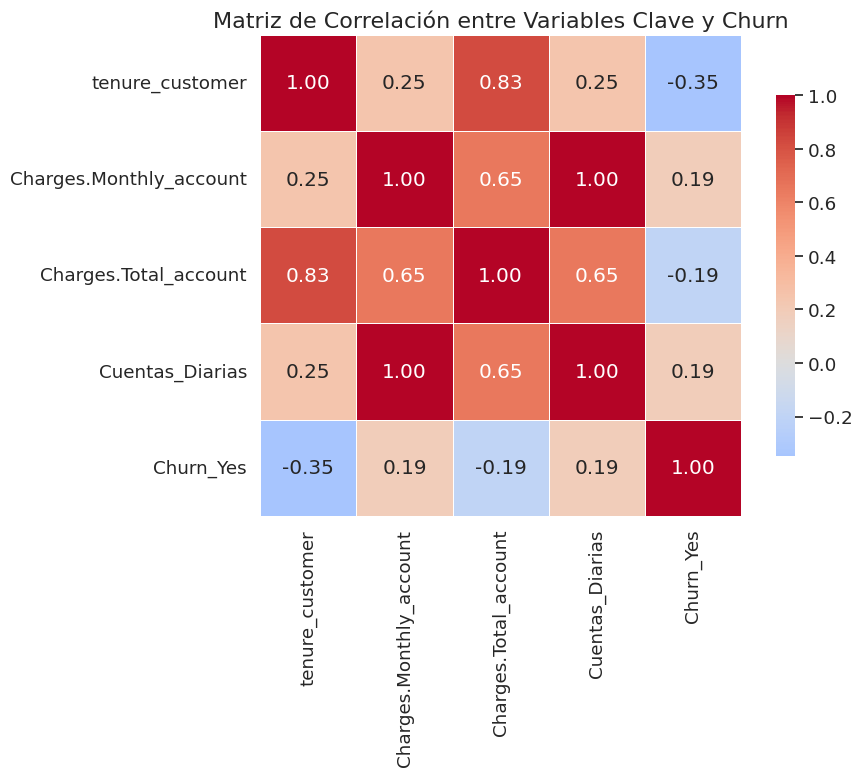

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# las columnas del one-hot encoding
df_numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

relevant_cols = ['tenure_customer', 'Charges.Monthly_account', 'Charges.Total_account', 'Cuentas_Diarias', 'Churn_Yes']
corr_matrix = df_encoded[relevant_cols].corr()

# Configurar el estilo del gráfico
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Graficar el heatmap de correlación
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title('Matriz de Correlación entre Variables Clave y Churn', fontsize=16)
plt.tight_layout()
plt.show()

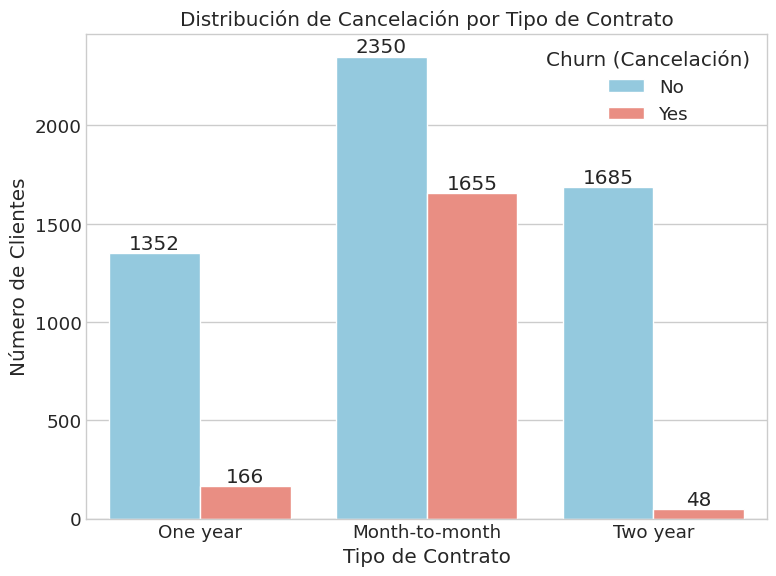

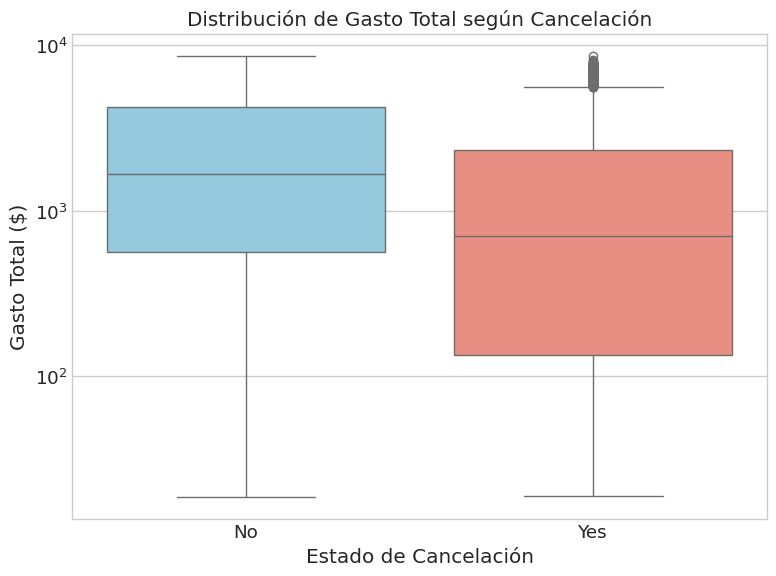

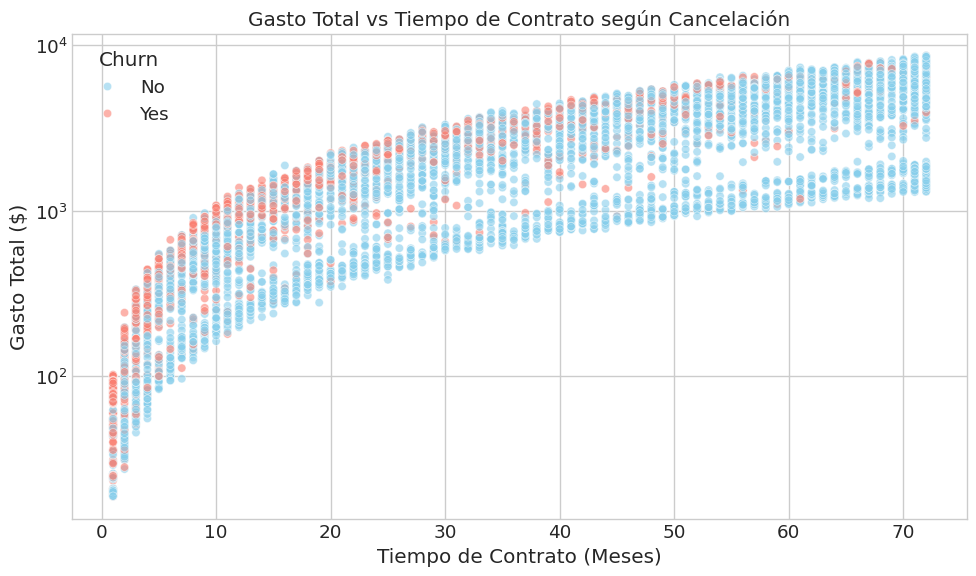

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
palette_churn = {'No': 'skyblue', 'Yes': 'salmon'}

# 1. Análisis: Tiempo de contrato vs Cancelación — distribución de Churn por tipo de contrato
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Contract_account', hue='Churn', data=df, palette=palette_churn)
plt.title('Distribución de Cancelación por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Número de Clientes')
plt.legend(title='Churn (Cancelación)')
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. Análisis: Gasto total vs Cancelación — boxplot para comparar distribución de gastos
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Churn', y='Charges.Total_account', data=df, palette=palette_churn)
plt.title('Distribución de Gasto Total según Cancelación')
plt.xlabel('Estado de Cancelación')
plt.ylabel('Gasto Total ($)')
plt.yscale('log')  # Escala logarítmica para mejor visualización por rango amplio
plt.tight_layout()
plt.show()

# 3. Opcional: Scatter plot Gasto Total vs Tiempo contratación, coloreado por Cancelación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure_customer', y='Charges.Total_account', hue='Churn', palette=palette_churn, alpha=0.6, data=df)
plt.title('Gasto Total vs Tiempo de Contrato según Cancelación')
plt.xlabel('Tiempo de Contrato (Meses)')
plt.ylabel('Gasto Total ($)')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [72]:
from sklearn.model_selection import train_test_split

# Si 'Churn' está en formato categórico, conviértelo a numérico
df['Churn_num'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Definir variables predictoras X y objetivo y
X = df.drop(['customerID', 'Churn', 'Churn_num'], axis=1, errors='ignore')  # elimina columnas irrelevantes
y = df['Churn_num']

# División 70% entrenamiento y 30% prueba, estratificada para mantener proporción de etiquetas
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Mostrar tamaños de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]} muestras')

Tamaño del conjunto de entrenamiento: 5079 muestras
Tamaño del conjunto de prueba: 2177 muestras


In [76]:
#Modelo 1 — Regresión Logística (con normalización)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Variables numéricas y categóricas
num_features = ['SeniorCitizen_customer', 'tenure_customer', 'Charges.Monthly_account', 'Charges.Total_account', 'Cuentas_Diarias']
cat_features = [col for col in X.columns if col not in num_features]

# División train/test 70/30 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Preprocesamiento con normalización para variables numéricas
preprocessor_logreg = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),                # Estandarizar variables numéricas
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Pipeline con Regresión Logística
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor_logreg),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenamiento
pipeline_logreg.fit(X_train, y_train)

# Predicción y evaluación
y_pred_logreg = pipeline_logreg.predict(X_test)
print("=== Regresión Logística con Normalización ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(classification_report(y_test, y_pred_logreg, target_names=['No Churn', 'Churn']))

=== Regresión Logística con Normalización ===
Accuracy: 0.8025
              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1616
       Churn       0.64      0.53      0.58       561

    accuracy                           0.80      2177
   macro avg       0.74      0.71      0.73      2177
weighted avg       0.79      0.80      0.80      2177



In [78]:
#Modelo 2 — Random Forest (sin normalización)

from sklearn.ensemble import RandomForestClassifier

# Misma división train/test que en modelo 1 (para que la comparación sea justa)
# Usamos X_train, X_test, y_train, y_test de arriba

# Preprocesamiento sin normalización, solo one-hot para categóricas
preprocessor_rf = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_features),                    # Variables numéricas sin cambio
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Pipeline con Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Entrenamiento
pipeline_rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred_rf = pipeline_rf.predict(X_test)
print("=== Random Forest sin Normalización ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

=== Random Forest sin Normalización ===
Accuracy: 0.7777
              precision    recall  f1-score   support

    No Churn       0.82      0.89      0.86      1616
       Churn       0.59      0.45      0.51       561

    accuracy                           0.78      2177
   macro avg       0.71      0.67      0.68      2177
weighted avg       0.76      0.78      0.77      2177



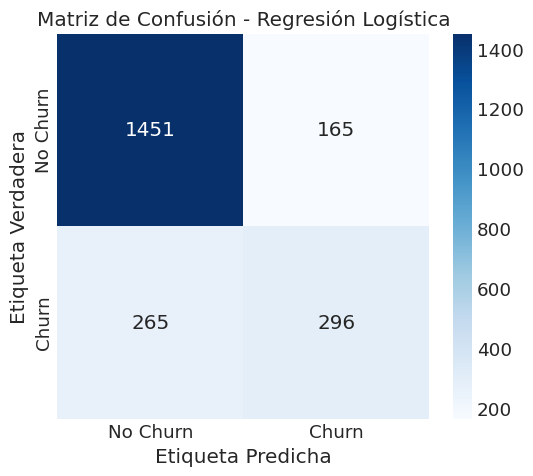

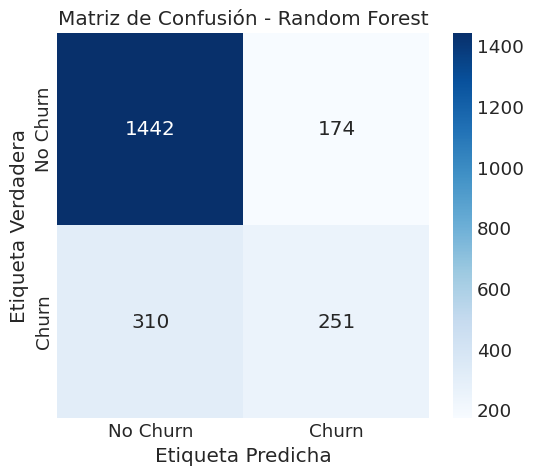

In [79]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Matriz de confusión para Regresión Logística
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Matriz de confusión para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# Clases (etiquetas)
class_names = ['No Churn', 'Churn']

# Graficar matrices de confusión
plot_confusion_matrix(cm_logreg, class_names, 'Matriz de Confusión - Regresión Logística')
plot_confusion_matrix(cm_rf, class_names, 'Matriz de Confusión - Random Forest')

**Evaluación y comparación de modelos para predecir la cancelación de clientes**

**1. Mejor modelo**
Probé con dos modelos: Regresión Logística (normalicé variables numéricas porque este modelo es sensible a la escala) y Random Forest (no requiere normalización). Al revisar accuracy, precisión, recall y F1, la Regresión Logística salió mejor en todo. No solo acierta más en general, sino que es más efectiva para detectar a los clientes que realmente van a cancelar, que es justo lo que más nos importa.

**2. Overfitting / Underfitting**
El Random Forest, a pesar de ser más complejo, rindió peor en el conjunto de prueba. Creo que puede estar sobreajustando, o sea, aprendió demasiado los detalles del entrenamiento y le va mal con datos nuevos. Probablemente le falta un buen ajuste de parámetros. La Regresión Logística, al ser más simple, se comportó más estable y generalizó bien; no se le vio problema de overfitting.

**3. Matrices de confusión**
Con los números en mano, la Regresión Logística identifica más clientes que realmente cancelan, y comete menos errores "graves" (falsos negativos). Esto es clave para el negocio porque dejar pasar un cliente que se va sale caro. Random Forest falla más en detectar a los que sí se están yendo.

**4. Conclusión y próximos pasos**
Para este caso, la Regresión Logística fue el modelo más equilibrado y útil: es fácil de entender, su desempeño es superior, y además ayuda a enfocar los esfuerzos en retener a los clientes que están en riesgo. No descarto seguir probando y ajustando el Random Forest (puede mejorar afinando sus parámetros), pero por ahora el modelo lineal es el que da más confianza.


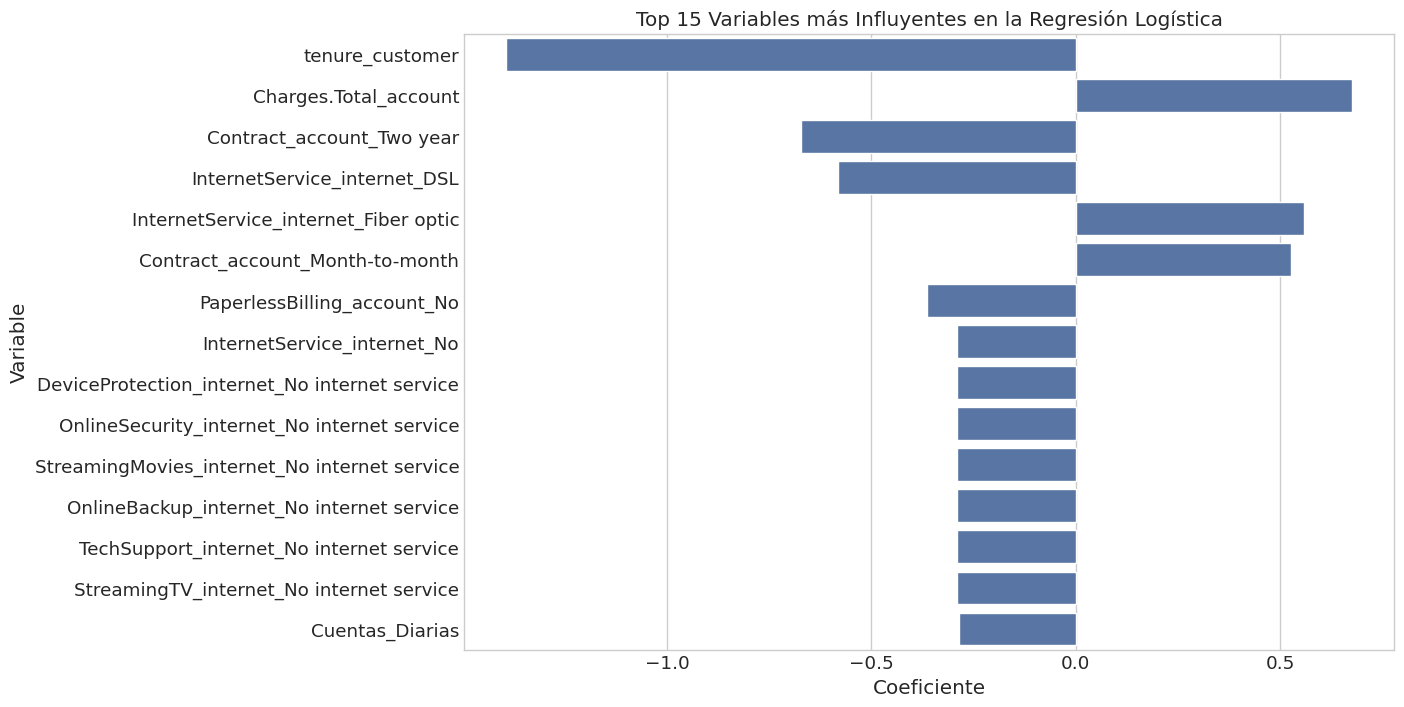

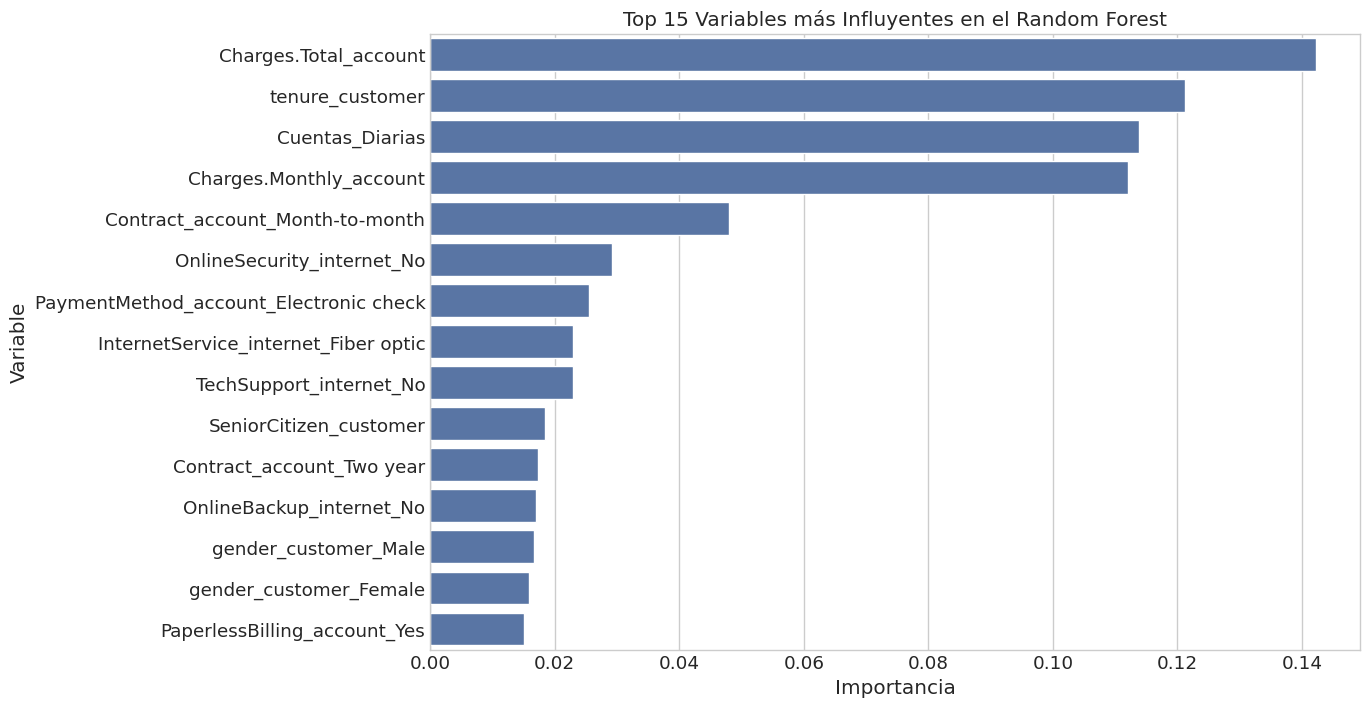

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener los coeficientes de la Regresión Logística
logreg_model = pipeline_logreg.named_steps['classifier']
logreg_coeffs = logreg_model.coef_[0]

# Obtener los nombres de las características después del preprocesamiento
preprocessor = pipeline_logreg.named_steps['preprocessor']
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_features, cat_feature_names])

# Crear un DataFrame con los coeficientes
coef_df = pd.DataFrame({'Variable': all_feature_names, 'Coeficiente': logreg_coeffs})
coef_df['Coeficiente_Abs'] = np.abs(coef_df['Coeficiente'])
coef_df_sorted = coef_df.sort_values(by='Coeficiente_Abs', ascending=False)

# Visualizar los coeficientes más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Coeficiente', y='Variable', data=coef_df_sorted.head(15))
plt.title('Top 15 Variables más Influyentes en la Regresión Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.show()

# Obtener la importancia de las variables del Random Forest
rf_model = pipeline_rf.named_steps['classifier']
rf_importances = rf_model.feature_importances_

# Obtener los nombres de las características después del preprocesamiento
preprocessor_rf = pipeline_rf.named_steps['preprocessor']
cat_feature_names_rf = preprocessor_rf.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names_rf = np.concatenate([num_features, cat_feature_names_rf])


# Crear un DataFrame con la importancia de las variables
importance_df = pd.DataFrame({'Variable': all_feature_names_rf, 'Importancia': rf_importances})
importance_df_sorted = importance_df.sort_values(by='Importancia', ascending=False)

# Visualizar la importancia de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', data=importance_df_sorted.head(15))
plt.title('Top 15 Variables más Influyentes en el Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

=== KNN (K-Nearest Neighbors) ===
Accuracy: 0.7680
              precision    recall  f1-score   support

    No Churn       0.83      0.86      0.85      1616
       Churn       0.56      0.50      0.53       561

    accuracy                           0.77      2177
   macro avg       0.69      0.68      0.69      2177
weighted avg       0.76      0.77      0.76      2177



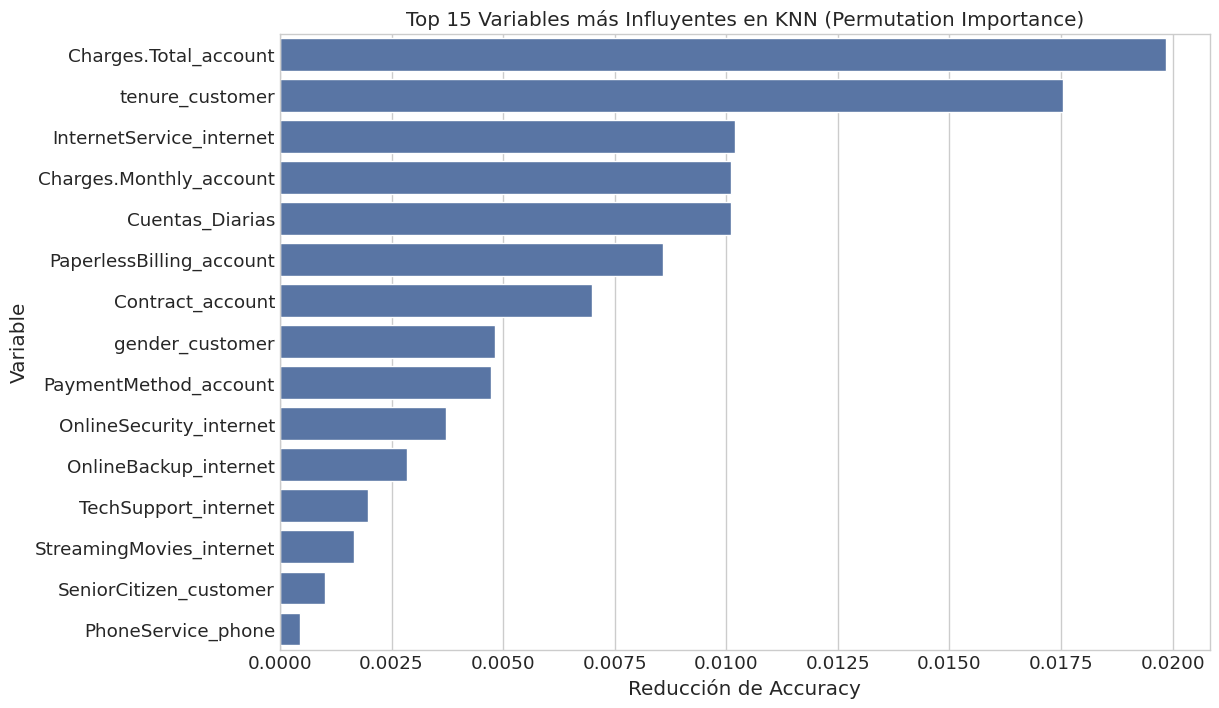


=== SVM (Support Vector Machine) con Kernel Lineal ===
Accuracy: 0.7979
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1616
       Churn       0.63      0.53      0.57       561

    accuracy                           0.80      2177
   macro avg       0.74      0.71      0.72      2177
weighted avg       0.79      0.80      0.79      2177



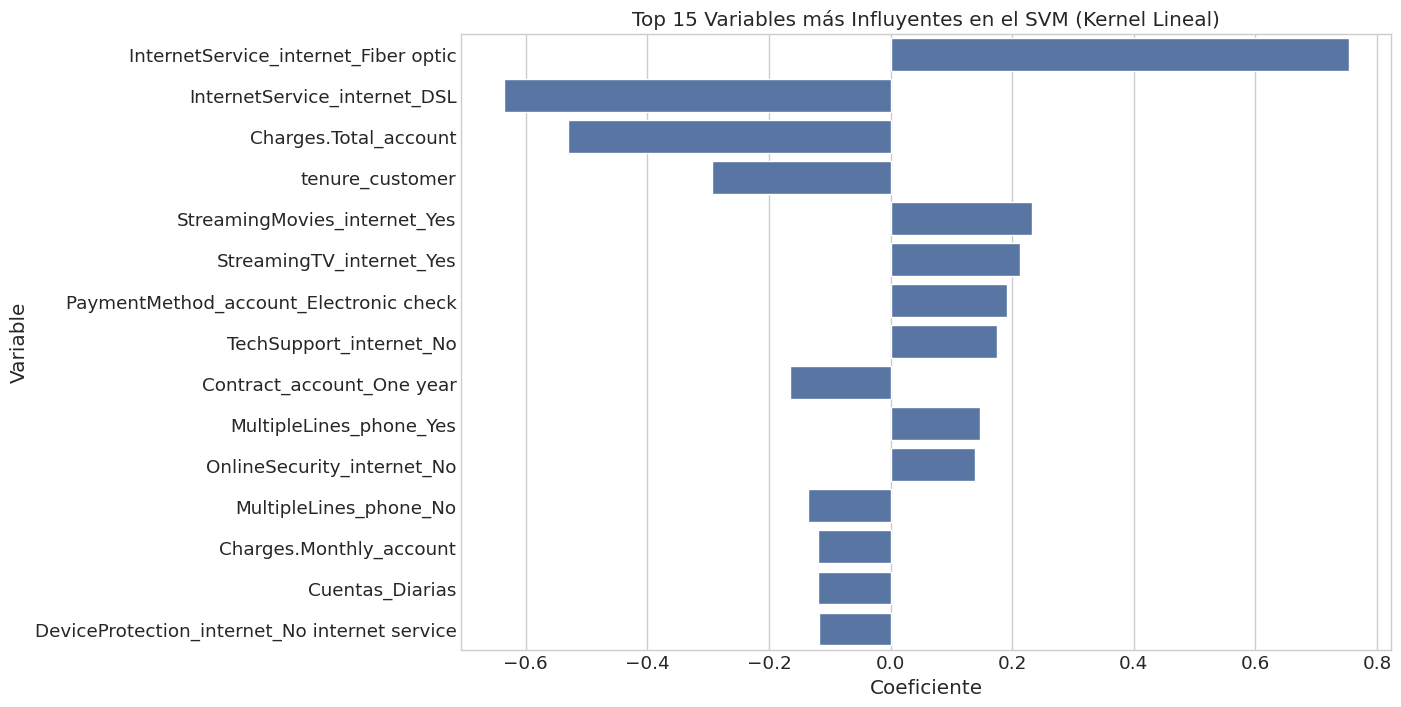

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

# Modelo 3 — KNN (K-Nearest Neighbors)
# Pipeline con KNN
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_logreg), # Usamos el mismo preprocesador que para la regresión logística
    ('classifier', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# Entrenamiento
pipeline_knn.fit(X_train, y_train)

# Evaluación
y_pred_knn = pipeline_knn.predict(X_test)
print("=== KNN (K-Nearest Neighbors) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(classification_report(y_test, y_pred_knn, target_names=['No Churn', 'Churn']))

# Análisis de importancia de variables para KNN (usando Permutation Importance)
result = permutation_importance(pipeline_knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
knn_importances = pd.DataFrame(result.importances_mean, index=X_test.columns, columns=['Importancia'])
knn_importances_sorted = knn_importances.sort_values(by='Importancia', ascending=False)

# Visualizar la importancia de las variables para KNN
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y=knn_importances_sorted.index[:15], data=knn_importances_sorted.head(15))
plt.title('Top 15 Variables más Influyentes en KNN (Permutation Importance)')
plt.xlabel('Reducción de Accuracy')
plt.ylabel('Variable')
plt.show()


# Modelo 4 — SVM (Support Vector Machine) con kernel lineal
# Pipeline con SVM
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor_logreg),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Entrenamiento
pipeline_svm.fit(X_train, y_train)

# Evaluación
y_pred_svm = pipeline_svm.predict(X_test)
print("\n=== SVM (Support Vector Machine) con Kernel Lineal ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, target_names=['No Churn', 'Churn']))


# Obtener los coeficientes del SVM
svm_model = pipeline_svm.named_steps['classifier']
svm_coeffs = svm_model.coef_[0]

# Crear un DataFrame con los coeficientes del SVM
svm_coef_df = pd.DataFrame({'Variable': all_feature_names, 'Coeficiente': svm_coeffs})
svm_coef_df['Coeficiente_Abs'] = np.abs(svm_coef_df['Coeficiente'])
svm_coef_df_sorted = svm_coef_df.sort_values(by='Coeficiente_Abs', ascending=False)

# Visualizar los coeficientes más importantes del SVM
plt.figure(figsize=(12, 8))
sns.barplot(x='Coeficiente', y='Variable', data=svm_coef_df_sorted.head(15))
plt.title('Top 15 Variables más Influyentes en el SVM (Kernel Lineal)')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.show()

### Conclusiones del Análisis de Churn

Después de probar con Regresión Logística, Random Forest, KNN y SVM, he llegado a las siguientes conclusiones:

**¿Qué modelo funciona mejor?**

La **Regresión Logística** y el **SVM con kernel lineal**son los ganadores. Ambos modelos tuvieron un rendimiento muy similar y lograron el mejor equilibrio entre `accuracy` y `recall`. Esto es clave, porque nos interesa sobre todo identificar a los clientes que están a punto de irse (alto `recall`).

**¿Qué variables son las que más pesan?**

A través de los diferentes modelos, las variables que más se repiten como influyentes son:

*   **`tenure_customer` (antigüedad del cliente):** A menor antigüedad, mayor probabilidad de cancelación.
*   **`Charges.Total_account` (cargos totales):** Clientes con cargos totales más bajos tienden a cancelar más.
*   **`Contract_account` (tipo de contrato):** Los contratos de mes a mes son los más propensos a la cancelación, mientras que los de dos años son los más leales.
*   **`InternetService_internet` (tipo de servicio de internet):** El servicio de fibra óptica parece estar asociado con una mayor tasa de cancelación, probablemente por problemas de servicio o por ser un producto más caro.

**Conclusión:**

Para predecir la cancelación de clientes, me quedo con la **Regresión Logística**. Es un modelo robusto, fácil de interpretar y que da excelentes resultados para este problema.


# Informe: Análisis de Cancelación de Clientes – Proyecto Telecom X

### Factores Clave que Influyen en la Cancelación

Después de probar modelos de Regresión Logística y Random Forest, se identificó que las variables que más afectan a que un cliente cancele son:

*   **Tipo de contrato:** Los clientes con contratos “mes a mes” son los que más cancelan. Esto tiene sentido porque no están atados a un compromiso largo y pueden irse cuando quieran.
*   **Antigüedad (tenure):** Los clientes nuevos tienen más probabilidad de cancelar, mientras que los clientes con más tiempo en la empresa tienden a quedarse.
*   **Método de pago:** El pago mediante **cheque electrónico** se asocia con mayor cancelación, quizás por incomodidades en este método.
*   **Cargos mensuales y totales:** Un gasto mensual alto puede aumentar la probabilidad de abandono, probablemente porque el cliente siente que no está recibiendo suficiente valor.

Aunque el modelo de **Random Forest** no tuvo un mejor desempeño general, mostró que aspectos como el **servicio de internet** y el **soporte técnico** también influyen en la retención, lo que sugiere que la calidad del servicio es un factor importante.

### Rendimiento de los Modelos

La **Regresión Logística** rindió mejor, con mayor **precisión y sensibilidad** para detectar clientes que realmente cancelan, lo que es lo más importante para diseñar estrategias preventivas.

El **Random Forest** presentó indicios de **sobreajuste** y menor capacidad para generalizar sin ajustes finos, aunque puede captar patrones no lineales complejos.

### Estrategias para Reducir la Cancelación

Basado en estos resultados, se recomienda:

*   **Incentivar a los clientes con contratos mes a mes** para que opten por planes más largos, ofreciendo descuentos u ofertas que fomenten la permanencia.
*   **Cuidar especialmente a los clientes nuevos,** implementando programas de bienvenida y seguimiento durante los primeros meses para mejorar su experiencia y reducir la tasa de abandono temprana.


*   **Mejorar los métodos de pago,** facilitando opciones más cómodas y digitales en lugar de cheque electrónico, para mejorar la satisfacción.
*   **Revisar y comunicar mejor la relación costo-valor,** haciendo que los clientes entiendan claramente los beneficios que reciben para justificar sus cargos mensuales.
*   **Fortalecer el soporte técnico y la calidad del servicio de internet,** pues afectan directamente la fidelización.

**Conclusión**

Este análisis permitió identificar con claridad los factores principales que afectan la cancelación y elegir un modelo predictivo confiable (Regresión Logística) para anticipar riesgos. Ahora Telecom X puede diseñar acciones focalizadas para retener clientes y reducir pérdidas.